In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
torch.cuda.is_available()

True

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
def load_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)
#def load_data(L,temp,MCS):
#    return np.fromfile(f"/content/drive/MyDrive/ising_data/dataIsing2D_L10/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

3.22

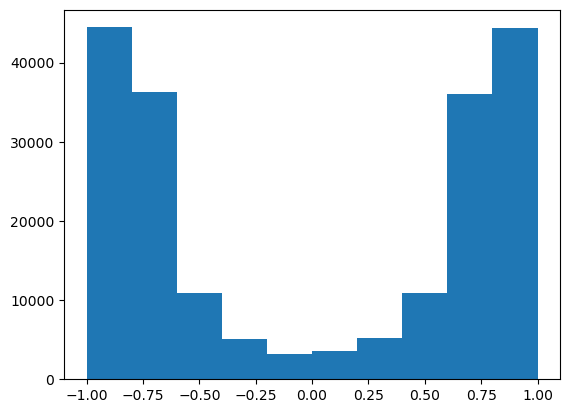

In [43]:
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)
L = 14
#data = load_data(L,Ts[9],200000)
data = load_data(L,Ts[0],200000)
plt.hist(np.mean(data,axis = 1))
Ts[-1]

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


$\mathbf{W} = \left(\Delta_t \mathbf{1} + \mathbf{C}^0 e^{-2t}\right)^{-1}$

$\mathbf{M} = 3\Delta_t(\Delta_t + e^{-2t} ) \mathbf{1} +(3\Delta_t+e^{-2t})\mathbf{C}^0 e^{-2t} $

The equation for $g$ is:

$\text{Tr}(\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1})) - g \cdot\text{Tr}(x_i^2  (x_i^2-1)^2) + \cdots$ = 0

Let's get the matrix M and W

In [44]:
N =L**2
nSteps =300
dt = 0.02
diffTemp = np.linspace(1,1,nSteps)
def Deltat(n,dt,diffTemp):
    return diffTemp*(1-np.exp(-2*(n+1)*dt))

In [45]:
C0 = np.cov(data.T)
W = np.empty((nSteps,N,N))
invW = np.empty((nSteps,N,N))
M = np.empty((nSteps,N,N))
K = np.empty((nSteps,N,N))

In [46]:
for t in range(nSteps):
    Dt = Deltat(t,dt,diffTemp[t])
    exp2t=np.exp(-2*(t+1)*dt)
    invW[t] = Dt*np.eye(N) + C0*exp2t
    W[t] = np.linalg.inv(invW[t])
    M[t] = (3*Dt+exp2t)*C0*exp2t+ 3*Dt*(Dt + exp2t)*np.eye(N)

$\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1}) = \mathbf{W}\mathbf{M} - \mathbf{1} + g\cdot (-2\mathbf{M} + \mathbf{W}^{-1} + \mathbf{M}\mathbf{W}\mathbf{M}) = \mathbf{K} + g\cdot \mathbf{K_g}$

$ \text{Tr}\mathbf{K} + g\cdot \text{Tr}\mathbf{K_g} - gN\cdot \mathbf{C}_6  - N\mathbf{C_4} = 0$

In [47]:
K = np.matmul(W,M) - np.eye(W.shape[1])
K_g = -2*M + invW + np.matmul(M,np.matmul(W,M))

Now the other terms

In [48]:
ts= np.array([*range(nSteps)])
Dts = Deltat(ts,dt,diffTemp)
expts = np.exp(-2*(ts+1)*dt)
C6 = Dts*(15*Dts**2 - 6*Dts + 1) + expts *(45*Dts**2 - 12*Dts + 1) + expts**2 * (15*Dts-2) + expts**3
C4 = (3*(Dts+expts)-1)

$g = -\frac{\text{Tr}(\mathbf{K}) - \mathbf{C}_4}{\text{Tr}(\mathbf{K}_g) - \mathbf{C}_6}$

In [49]:
num = np.trace(K,axis1=1,axis2=2) - N*C4
den = np.trace(K_g,axis1=1,axis2=2) - N*C6
g = -num/den

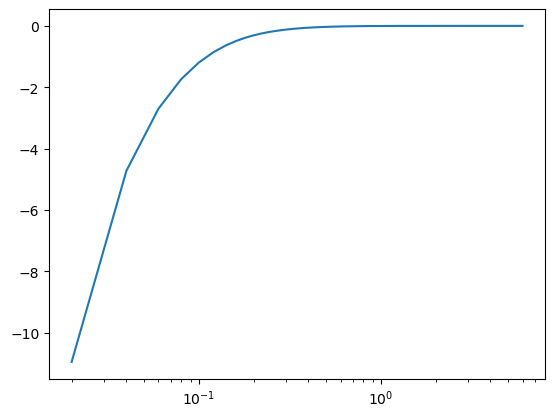

In [50]:
plt.plot((ts+1)*dt,g)
#plt.yscale("log")
plt.xscale("log")
#plt.axvline(dt*2)

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


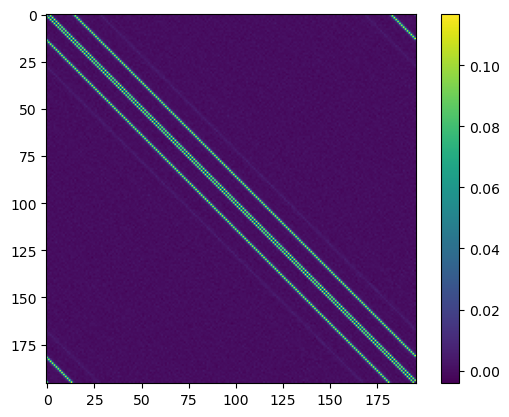

In [51]:
#MW = g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(N).reshape(1,N,N))
A =  W + g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(N).reshape(1,N,N))
#A = W
#plt.imshow(MW[0]-np.diag(np.diag(MW[0])))
plt.imshow(-A[0]+np.diag(np.diag(A[0])))
#plt.imshow(A[0])
plt.colorbar()

In [52]:
def myscore(x,A,g,device = "cuda"):
    return  -torch.matmul(x,A.T) + g*x*(x**2-1)

In [53]:
def backward(xT,A,g,temp,nSteps,dt,full_traj = False,every = 5,device = "cuda"):
    P = xT.shape[0]
    N = xT.shape[1]
    A =torch.from_numpy(A).to(device).to(torch.float32)
    g =torch.from_numpy(g).to(device).to(torch.float32)
    nbatches = 50
    batch_size = int(P/nbatches)
    tts = np.linspace(1,nSteps,nSteps-1,dtype = np.int32)
    if(full_traj):
        redSteps = int(nSteps/every)
        tslice = np.linspace(1,nSteps+1,redSteps,dtype = np.int32)
        x_recon = torch.Tensor(P,redSteps,N).to(device)
        x_now =xT.to(device)
    else:
        x_recon = xT.to(device)
    with torch.no_grad():
        for tt in tts[::-1]:
            std = np.sqrt(2*temp[tt-1]*dt)*torch.randn_like(xT).to(device)
            #if tt==1:
            #    std = torch.zeros(xT.shape)

            for n in range(nbatches):
                if(full_traj):
                    score = myscore(x_now[n*batch_size:(n+1)*batch_size,:], A[tt-1],g[tt-1],device)
                    x_now[n*batch_size:(n+1)*batch_size,:] = x_now[n*batch_size:(n+1)*batch_size,:]*(1+dt) + 2*temp[tt-1]*score*dt + std[n*batch_size:(n+1)*batch_size]
                    if(tt in tslice):
                        x_recon[n*batch_size:(n+1)*batch_size,np.where(tslice==tt)[0][0],:]=x_now[n*batch_size:(n+1)*batch_size,:]
                else:
                    score = myscore(x_recon[n*batch_size:(n+1)*batch_size], A[tt-1],g[tt-1],device)
                    x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp[tt-1]*score*dt + std[n*batch_size:(n+1)*batch_size]
                del score
    
    return x_recon.to("cpu").numpy()

In [54]:
P = 100000
N = L**2
xT = np.sqrt(diffTemp[-1])*torch.randn((P,N))
x_recon = backward(xT,A,g,diffTemp,nSteps,dt,full_traj=False,device= "cuda")

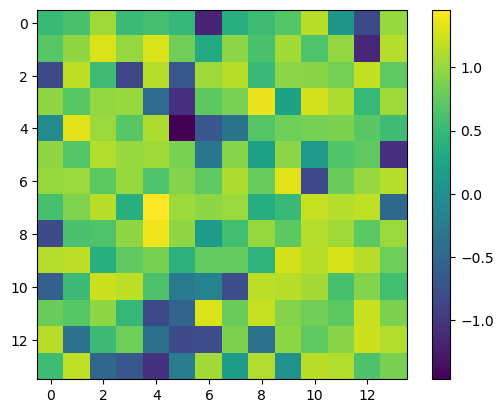

In [55]:
plt.imshow(x_recon[2].reshape(L,L))
plt.colorbar()
#plt.scatter([*range(L)],x_recon[3].reshape(L,L)[6])

In [56]:
from scipy.stats import kurtosis, skew
print(skew(np.mean(x_recon,axis = 1)))
print(kurtosis(np.mean(x_recon,axis = 1)))
print(kurtosis(np.mean(data,axis = 1)))

-0.0018284766308253695
-1.0483872952057331
-1.830189963137682


(array([0.5439525, 1.6174725, 1.2286575, 0.74466  , 0.38388  , 0.2335725,
        0.16842  , 0.1133475, 0.0958125, 0.0832125, 0.0759675, 0.0785925,
        0.104685 , 0.1134   , 0.1581825, 0.25704  , 0.3779475, 0.6400275,
        1.3181175, 1.6137975, 0.549255 ]),
 array([-1.        , -0.9047619 , -0.80952381, -0.71428571, -0.61904762,
        -0.52380952, -0.42857143, -0.33333333, -0.23809524, -0.14285714,
        -0.04761905,  0.04761905,  0.14285714,  0.23809524,  0.33333333,
         0.42857143,  0.52380952,  0.61904762,  0.71428571,  0.80952381,
         0.9047619 ,  1.        ]),
 <BarContainer object of 21 artists>)

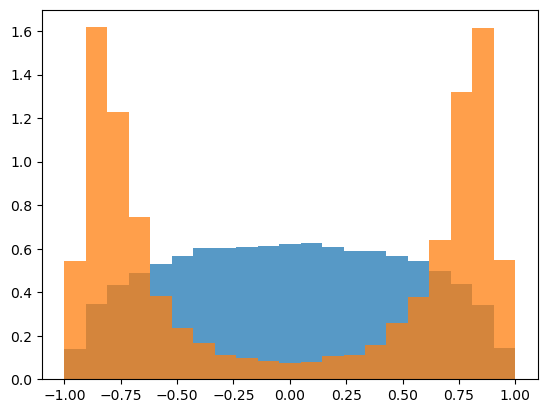

In [57]:
plt.hist(np.mean(x_recon,axis = 1),bins = 21,range = (-1,1),density=True,alpha = 0.75)
#plt.hist(np.mean(np.sign(x_recon),axis = 1),bins = 21,range = (-1,1),density=True,alpha = 0.75)
plt.hist(np.mean(data,axis = 1),bins = 21,range = (-1,1),density=True,alpha = 0.75)

(array([0.55285034, 0.72825581, 0.74474317, 0.62933431, 0.4711959 ,
        0.32817868, 0.24691439, 0.21033092, 0.19628282, 0.17969829,
        0.17384494, 0.18691744, 0.19267325, 0.21198938, 0.25559688,
        0.32925179, 0.45802583, 0.63304145, 0.74171893, 0.72484135,
        0.55431368]),
 array([-1.20000005, -1.08571434, -0.97142857, -0.85714287, -0.74285716,
        -0.62857145, -0.51428574, -0.40000001, -0.2857143 , -0.17142858,
        -0.05714286,  0.05714286,  0.17142858,  0.2857143 ,  0.40000001,
         0.51428574,  0.62857145,  0.74285716,  0.85714287,  0.97142857,
         1.08571434,  1.20000005]),
 <BarContainer object of 21 artists>)

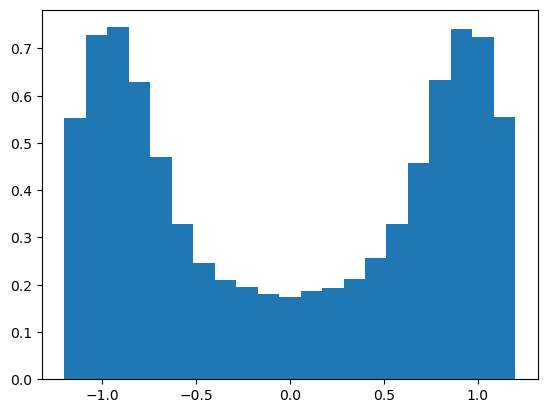

In [58]:
plt.hist(x_recon[:,2],range=(-1.2,1.2),bins = 21,density=True)

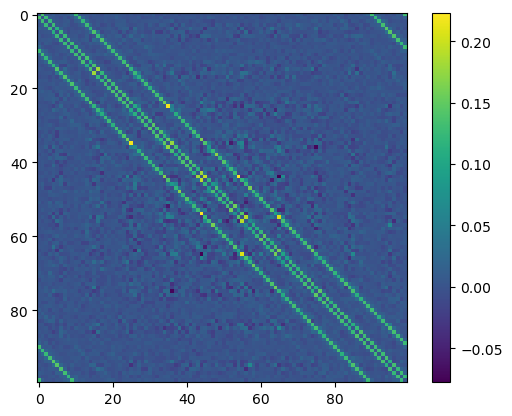

In [26]:
Jrecon = np.linalg.inv(np.cov(x_recon.T))
Jrecon = -Jrecon +np.diag(np.diag(Jrecon))
plt.imshow(Jrecon)
plt.colorbar()

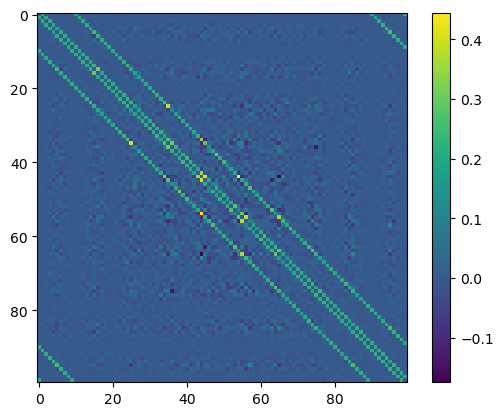

In [27]:
Jtrue = np.linalg.inv(np.cov(data.T))
#Jtrue = (np.cov(data.T))
Jtrue = -Jtrue +np.diag(np.diag(Jtrue))
plt.imshow(Jtrue)
plt.colorbar()

In [51]:
def getScoreParams(x0,diffTemp,dt,nSteps):
    N = x0.shape[1]
    C0 = np.cov(x0.T)
    W = np.empty((nSteps,N,N))
    invW = np.empty((nSteps,N,N))
    M = np.empty((nSteps,N,N))
    K = np.empty((nSteps,N,N))
    ts= np.array([*range(nSteps)])
    Dts = Deltat(ts,dt,diffTemp)
    exp2ts = np.exp(-2*(ts+1)*dt)

    for t in range(nSteps):
        invW[t] = Dts[t]*np.eye(N) + C0*exp2ts[t]
        W[t] = np.linalg.inv(invW[t])
        M[t] = (3*Dts[t]+exp2ts[t])*C0*exp2ts[t]+ 3*Dt[t]*(Dt[t] + exp2ts[t])*np.eye(N)
    
    K = np.matmul(W,M) - np.eye(W.shape[1])
    K_g = -2*M + invW + np.matmul(M,np.matmul(W,M))

    C6 = Dts*(15*Dts**2 - 6*Dts + 1) + expts *(45*Dts**2 - 12*Dts + 1) + expts**2 * (15*Dts-2) + expts**3
    C4 = 3*(Dts+expts)-1
    num = np.trace(K,axis1=1,axis2=2) - N*C4
    den = np.trace(K_g,axis1=1,axis2=2) - N*C6

    g = -num/den
    A =  W + g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(N).reshape(1,N,N))

    return A,g

In [52]:
device = "cuda"

In [53]:
def gen_noisy_data(x0,step,temp,dt,device = "cpu"):
    x0 = torch.from_numpy(x0).to(torch.float32)
    x0 = x0.to(device)
    step = step.to(device)
    noise = torch.randn_like(x0).to(device)
    exp_t =torch.exp(-dt*(step+1)).view(-1, 1).to(device)
    std_t = torch.sqrt(temp*(1-exp_t*exp_t))
    noisy_data = x0*exp_t + noise*std_t
    return noisy_data, -noise/std_t
noisy = torch.Tensor(50000,nSteps,N).to(device)
diffTemp_cp = torch.from_numpy(diffTemp).to(device)
with torch.no_grad():
    for t in ts:
        tt = torch.Tensor([[t,]]).to(torch.float32).to(device)
        noisy[:,t,:], tmp = gen_noisy_data(data[:50000],tt,1,dt,device)
        del tmp
    noisy = noisy.cpu().numpy()
    #plt.plot(ts*dt,C4)

OutOfMemoryError: CUDA out of memory. Tried to allocate 10.95 GiB. GPU 0 has a total capacity of 7.89 GiB of which 5.24 GiB is free. Including non-PyTorch memory, this process has 644.00 MiB memory in use. Process 3885 has 880.00 MiB memory in use. Of the allocated memory 8.12 MiB is allocated by PyTorch, and 79.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:

C6_true = np.mean(noisy**2*(noisy**2-1)**2,axis = 0)
C4_true = np.mean(noisy**2*(noisy**2-1),axis = 0) - np.mean(data[:50000].reshape(50000,1,N)*noisy*(noisy**2-1)*np.exp(-ts.reshape(1,300,1)*dt),axis = 0)

In [27]:
C6_true.shape

(300, 64)

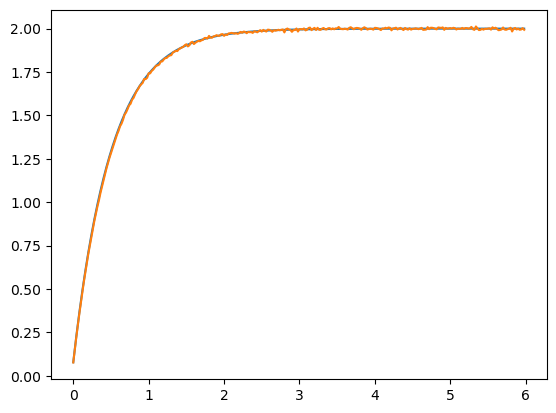

In [63]:
plt.plot(ts*dt,C4)
plt.plot(ts*dt,np.mean(C4_true,axis = 1))

In [32]:
slices = np.geomspace(1,299,10,dtype = np.int32)

In [49]:
M_true = np.mean(np.matmul(noisy[:,slices,:].reshape(50000,10,64,1)**3,noisy[:,slices,:].reshape(50000,10,1,64)),axis = 0)

In [50]:
M_true.shape

(10, 64, 64)

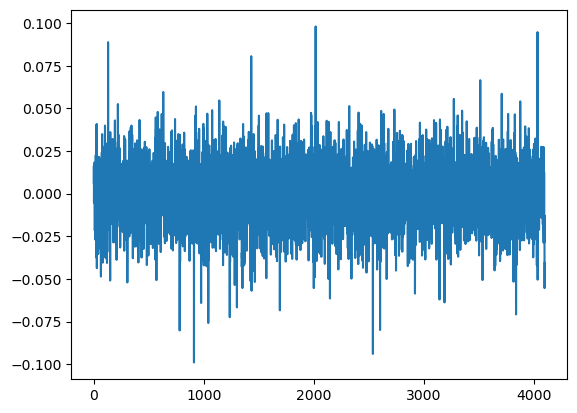

In [61]:
idx = 9
plt.plot([*range(64*64)],M_true[idx].reshape(64*64)-M[slices[idx]].reshape(64*64))
#plt.plot([*range(64*64)],M[slices[0]].reshape(64*64))

In [22]:
a = np.zeros((100,10,5))


In [26]:
c = np.matmul(a.reshape(100,10,5,1),a.reshape(100,10,1,5))
c.shape

(100, 10, 5, 5)